In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Seteo de learining rate:

https://arxiv.org/abs/1506.01186

In [9]:
import numpy as np

In [10]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset_v3'
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]
classes = list(annotations_dict_train.keys())
print(classes)

['n02165456', 'n02226429', 'n01644373', 'n02279972', 'n01632458', 'n02256656', 'n01774384', 'n01770393']


In [11]:
from object_detection_helper import GeneratorMultipleOutputs, plot_batch, PlotLosses

In [12]:
target_size=(320, 320)

In [17]:
# classes en None para que tome world tambien
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 32, classes = classes,
                                                            concat_output = True,
                                                            target_size=target_size
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 32, classes = classes,
                                                              concat_output = True,
                                                          target_size=target_size
                                                         )

Found 2400 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


[0.   0.   0.   0.   0.   0.   1.   0.   0.48 0.44 0.27 0.21]


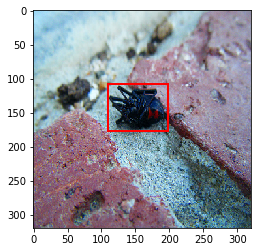

[0.   0.   0.   0.   0.   0.   1.   0.   0.56 0.72 0.28 0.53]


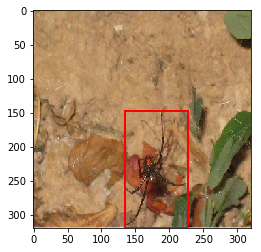

[0.   0.   1.   0.   0.   0.   0.   0.   0.55 0.51 0.21 0.34]


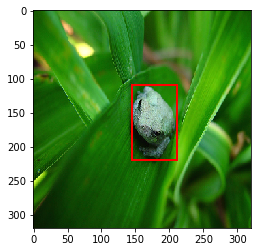

[0.   0.   0.   0.   0.   1.   0.   0.   0.32 0.41 0.62 0.82]


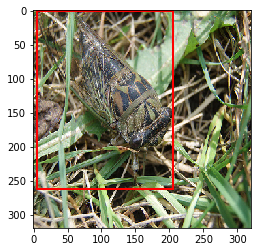

[0.   0.   0.   0.   0.   0.   1.   0.   0.45 0.49 0.91 0.99]


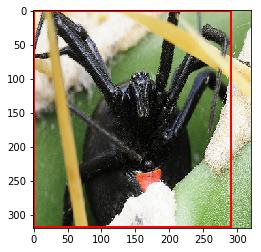

[1.   0.   0.   0.   0.   0.   0.   0.   0.44 0.5  0.24 0.26]


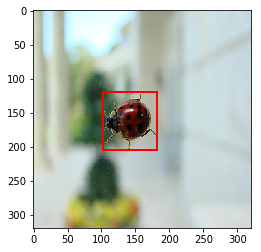

[0.   0.   0.   0.   1.   0.   0.   0.   0.52 0.52 0.82 0.54]


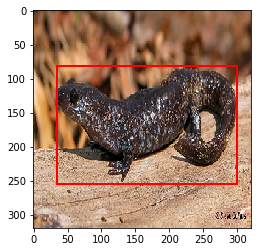

[0.   0.   0.   0.   0.   1.   0.   0.   0.49 0.49 0.47 0.83]


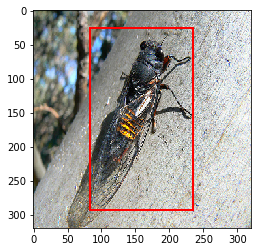

[0.   0.   0.   0.   1.   0.   0.   0.   0.46 0.57 0.31 0.5 ]


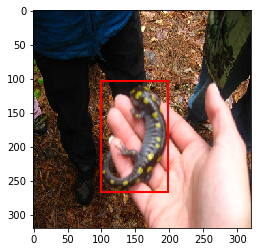

[0.   0.   0.   1.   0.   0.   0.   0.   0.36 0.45 0.72 0.71]


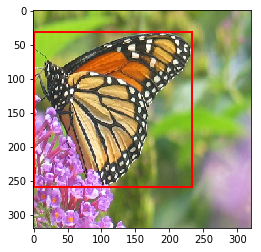

In [18]:
plot_batch(train_generator_multiple_outputs, count=10)

In [8]:
from keras.layers import Activation, Dropout, Dense, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, GlobalMaxPooling2D, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [9]:
from custom_losses import set_classes
set_classes(len(classes))
from custom_losses import n_classes
print('cantidad de clases:', n_classes)

cantidad de clases: 8


In [10]:
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=(*target_size, 3))

flatten_output = Flatten()(modelVGG16.output)
dense_1_output = Activation('relu')(Dense(128, name = 'Dense_1')(flatten_output))
dense_2_output = Activation('relu')(Dense(128, name = 'Dense_2')(dense_1_output))

classification = Dense(n_classes, activation='softmax', name='category_output')(dense_2_output)
bounding_box = Dense(4, activation=None, name='bounding_box')(Dropout(0.25)(dense_2_output))
confidence = Dense(1, activation='sigmoid', name='obj_confidence')(dense_2_output)

all_outs = Concatenate(name='concatenated_outputs')([classification, bounding_box, confidence])
model = Model(inputs=modelVGG16.input, outputs=[all_outs])

In [11]:
N_trainable = 17
print('primer capa entrenable:', model.layers[17].name)

for layer in model.layers[:N_trainable]:
    layer.trainable = False
for layer in model.layers[N_trainable:]:
    layer.trainable = True

primer capa entrenable: block5_conv3


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 160, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

![loss-func-obj-dect](loss-func-obj-dect.png)

# $L = \alpha L_{binary} + \beta L_{categorical} + \gamma L_{boundingbox}$

# Esto es si queremos importar la arquitectura de YOLOv2

In [108]:
# Solo correr esta celda si queremos importar la arquitectura de YOLOv2
from yolo_helper import get_YOLO_V2_NN
GRID_H,  GRID_W  = 10 , 10
IMAGE_H, IMAGE_W = GRID_H*32, GRID_W*32
target_size = (IMAGE_H, IMAGE_W)
print(IMAGE_H, IMAGE_W)
BOX = 1
CLASS = n_classes
model = get_YOLO_V2_NN(IMAGE_H, IMAGE_W, BOX, CLASS, GAP=True)
# Le pongo el mismo nombre que en el otro modelo para que asigne la loss bien
# model.layers[-1].name='concatenated_outputs'
model.layers[-1].output

320 320


<tf.Tensor 'concatenated_outputs_4/Mean:0' shape=(?, 13) dtype=float32>

In [109]:
model.count_params()

50561261

In [110]:
from custom_losses import bin_cross_entropy_loss, set_loss_weights, custom_loss_IOU, classes_acc, confidence_acc, bounding_box_mse, iou_v2, cat_cross_entropy_loss, custom_loss, mse_custom_loss

In [111]:
set_loss_weights(k_conf = 1.0, k_class = 1.0, k_bboxes = 120.0)

In [112]:
from yolo_helper import yolo_loss, bin_cross_entropy_loss, cat_cross_entropy_loss, set_classes, confidence_acc_with_sigmoid

In [113]:
set_classes(n_classes)

In [114]:
from yolo_helper import n_classes
n_classes

8

In [115]:
from custom_losses import n_classes
n_classes

8

In [116]:
#losses = {"concatenated_outputs": mse_custom_loss}
losses = {"concatenated_outputs": yolo_loss}
#losses = {"concatenated_outputs": custom_loss}
#losses = {"concatenated_outputs": custom_loss_IOU}

metrics = {"concatenated_outputs": [classes_acc, 
                                    confidence_acc_with_sigmoid,
                                    #confidence_acc, 
                                    bounding_box_mse, 
                                    iou_v2, 
                                    cat_cross_entropy_loss,
                                    bin_cross_entropy_loss
                                   ]}

In [146]:
train_generator = GeneratorMultipleOutputs(annotations_dict_train, 
                                           train_folder, 
                                           concat_output = True,
                                           batch_size=40, 
                                           target_size=target_size,
                                           flip = 'random')
val_generator = GeneratorMultipleOutputs(annotations_dict_val, 
                                         val_folder, 
                                         concat_output = True,
                                         target_size=target_size,
                                         batch_size=30,  
                                         flip = 'random')

Found 4800 images belonging to 9 classes.
Found 960 images belonging to 9 classes.


Found 960 images belonging to 9 classes.
(30, 320, 320, 3)


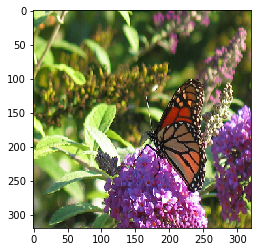

In [155]:
val_generator = GeneratorMultipleOutputs(annotations_dict_val, 
                                         val_folder, 
                                         concat_output = True,
                                         target_size=target_size,
                                         batch_size=30,  
                                         flip = 'random')
for data in val_generator:
    print(data[0].shape)
    plt.imshow(data[0][1])
    plt.show()
    break

In [147]:
val_generator.generator.batch_index

0

In [118]:
train_generator.generator.n % train_generator.generator.batch_size

0

In [119]:
val_generator.generator.n % val_generator.generator.batch_size

0

In [121]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_classes_acc', save_best_only=True)
model.compile(loss=losses,
              optimizer=SGD(lr=1e-8),
              metrics=metrics)

In [97]:
# model.load_weights('yolo_arq_1_box_0.0001_ds_v3.hdf5')

In [98]:
# model.evaluate_generator(val_generator_multiple_outputs)

In [99]:
from lr_helper import CyclicLR, LR_Find

In [127]:
step_size = 4*(train_generator.generator.n // train_generator.generator.batch_size)
print(step_size)

480


In [122]:
clr = CyclicLR(base_lr=1e-6, max_lr=1e-3, step_size=step_size)

In [102]:
lr_find = LR_Find(240)

In [103]:
model.fit_generator(
        train_generator,
        epochs=1,
        validation_data=val_generator, callbacks = [lr_find]
        )

/home/usuario/anaconda3/envs/gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
120/120 [==============================] - 49s 412ms/step - loss: 2.9125 - classes_acc: 0.1904 - confidence_acc_with_sigmoid: 0.5481 - bounding_box_mse: 0.2041 - iou_v2: 0.1136 - cat_cross_entropy_loss: 2.0073 - bin_cross_entropy_loss: 0.7012 - val_loss: 3.4890 - val_classes_acc: 0.2286 - val_confidence_acc_with_sigmoid: 0.6188 - val_bounding_box_mse: 0.2637 - val_iou_v2: 0.2112 - val_cat_cross_entropy_loss: 2.5876 - val_bin_cross_entropy_loss: 0.6378


In [106]:
lr_find.best

2.2175736

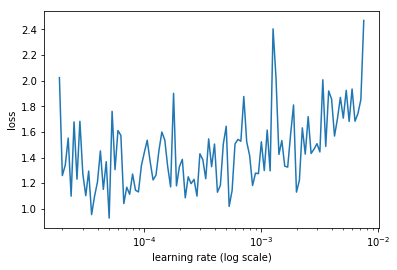

In [107]:
lf_find.plot()

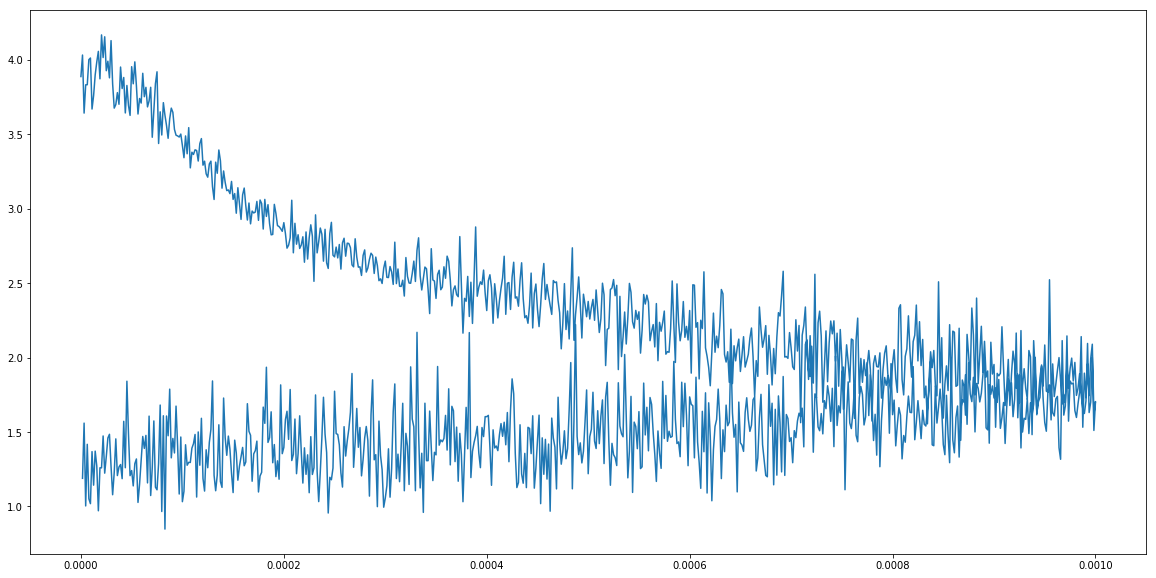

In [66]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(clr.history['lr'][:2*step_size], clr.history['loss'][:2*step_size])
#clr.history['loss']

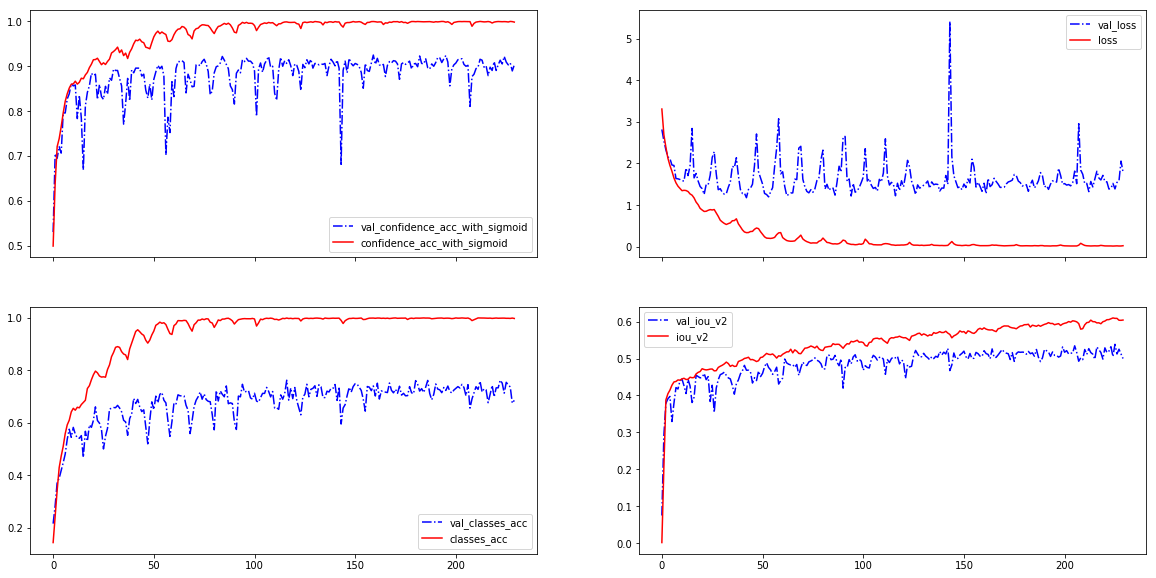

Epoch 231/2000
 50/120 [===========>..................] - ETA: 24s - loss: 0.0272 - classes_acc: 0.9979 - confidence_acc_with_sigmoid: 0.9985 - bounding_box_mse: 0.0088 - iou_v2: 0.6067 - cat_cross_entropy_loss: 0.0113 - bin_cross_entropy_loss: 0.0072

KeyboardInterrupt: 

In [123]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        epochs=2000,
        validation_data=val_generator, callbacks = [plot_losses, checkpoint, clr]
        )

In [ ]:
# model.save_weights('loc_last.hdf5')

In [55]:
model.load_weights('yolo_arq_1_box_0.0001_ds_v3_2.hdf5')

In [30]:
metrics_values = model.evaluate_generator(val_generator_multiple_outputs)
for i, met in enumerate(metrics_values):
    print(model.metrics_names[i], ':', met)

loss : 0.20466663936773935
classes_acc : 0.7976051489512126
confidence_acc : 0.934375
bounding_box_mse : 0.013085320002088945
iou_v2 : 0.6356569051742553
cat_cross_entropy_loss : 0.8619369586308797
bin_cross_entropy_loss : 0.379558310409387


Confidence OK: 0.99004126
Class OK: 4
IOU: [0.52465095]


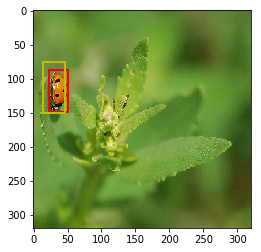

Confidence OK: 0.8416494
Class OK: 7
IOU: [0.58287936]


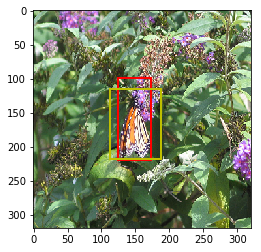

Confidence OK: -0.01631231


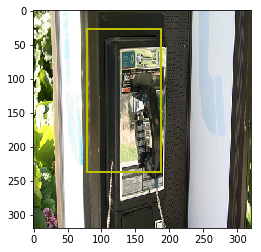

Confidence OK: 0.9873598
Class OK: 4
IOU: [0.93141079]


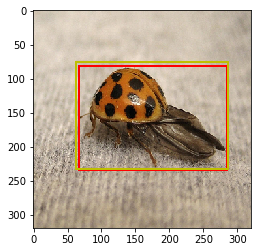

Confidence OK: 0.9916253
Class OK: 2
IOU: [0.76083061]


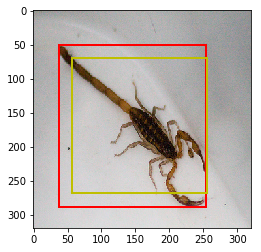

Confidence OK: 1.0008069
Class OK: 7
IOU: [0.73464545]


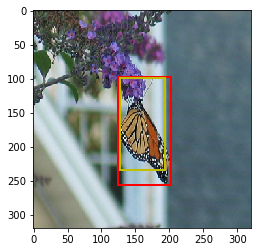

Confidence OK: 1.0083125
Class OK: 7
IOU: [0.64381442]


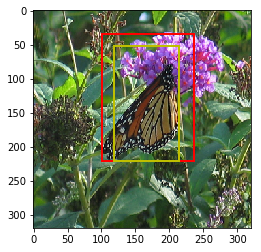

Confidence OK: 0.98899454
Class Failed: 6 5
IOU: [0.60000941]


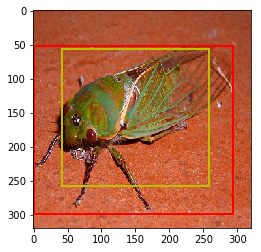

Confidence OK: 0.9910982
Class OK: 7
IOU: [0.81819714]


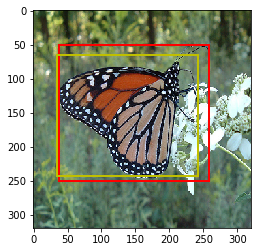

Confidence OK: 0.9921083
Class OK: 5
IOU: [0.6276259]


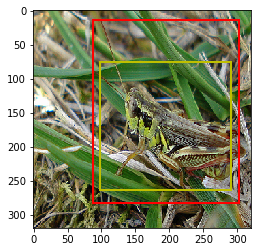

In [31]:
plot_batch(val_generator_multiple_outputs, model, count=10)